# Introduction

The Monty Hall Problem is something of a cultural phenomenon. The problem reveals that our intuition can often fail us on even simple problems. Many often struggle to understand the solution even after a thorough explanation, and an understanding of statistics is often needed. In this notebook, I hope to demonstrate the solution in a more practical and accessible way.

# Description of the Problem

The Monty Hall Problem has it's origin in the game show "Let's Make a Deal". A contestant would be asked to chose one of three doors behind which are two goats and a car. Once the contestant had made their choice, the host would open one of the doors to reveal a goat. The contestant would then be asked if they wanted to stay with their original choice or switch to the other unopened door.

When first presented the problem, an overwhelming amount of people believe that that its a 50/50 chance of winning the car between staying and switching. Even Paul Erdős (of the famous "Erdos Number") remained unconvinced until presented a computer simulation of the problem. Reading this was what inspired this short notebook.

# Demonstration

In [35]:
import random
import pandas as pd

In [15]:
def setting_up_the_doors():
    # decide the car door
    door_list = ["goat", "goat", "goat"]
    chosen_door = random.randint(0,2)
    door_list[chosen_door] = "car"
    return door_list   

In [16]:
def choose_a_door(door_list):
    chosen_door = random.randint(0,2)
    door_contains = door_list[chosen_door]

    return chosen_door

In [17]:
def reveal_goat(door_list, chosen_door):
    doors_with_goats = get_doors_with_goats(door_list)
    revealed_door = random.choice(doors_with_goats)
       
    if revealed_door == chosen_door:
        doors_with_goats.remove(revealed_door)
        revealed_door = doors_with_goats[0]
    
    return revealed_door

In [18]:
def get_doors_with_goats(door_list):
    doors_with_goats = [i for i, x in enumerate(door_list) if x == "goat"]
    return doors_with_goats

In [19]:
def switch(door_list, chosen_door, revealed_doors):
    doors_with_goats = get_doors_with_goats(door_list)
    door_numbers = [0,1,2]
    door_numbers.remove(chosen_door)
    door_numbers.remove(revealed_door)
    
    chosen_door = door_numbers[0]
    
    return chosen_door

In [20]:
def access_win(door_list, chosen_door):
    win = 0
    if (door_list[chosen_door]=='car'):
        win = 1
        
    return win

## Game Setup

In [21]:
doors = setting_up_the_doors()
chosen_door = choose_a_door(doors)
print("Door No.{} was chosen".format(chosen_door+1))
revealed_door = reveal_goat(doors, chosen_door)
print("Door No.{} was revealed to have a goat".format(revealed_door+1))

Door No.3 was chosen
Door No.2 was revealed to have a goat


## Staying

In [22]:
print("You chose to stay with your choice")
if access_win(doors, chosen_door) == 1:
    print("You win")
else:
    print ("you lose")

You chose to stay with your choice
you lose


## Switching

In [23]:
print("You chose to switch your choice")
switch_choice = switch(doors, chosen_door, revealed_door)
if access_win(doors, switch_choice) == 1:
    print("You win")
else:
    print ("you lose")

You chose to switch your choice
You win


# Test

## Simple Test

Now let's show the solution by running many Monty Hall Problems

In [11]:
numbers_of_games = 100
stay_win = 0
switch_win = 0

for x in range(numbers_of_games):
    doors = setting_up_the_doors()
    chosen_door = choose_a_door(doors)
    revealed_door = reveal_goat(doors, chosen_door)
    
    if access_win(doors, chosen_door) == 1:
        stay_win += 1
    else:
        switch_win += 1

print("The results are staying: {}% and switching: {}%".format(round(stay_win/numbers_of_games*100), round(switch_win/numbers_of_games*100)))      

The results are staying: 34% and switching: 66%


These results prove the solution

## Visualisation of Results

In [28]:
numbers_of_games = 100
stay_win = 0
switch_win = 0
win_list = []

for x in range(numbers_of_games):
    doors = setting_up_the_doors()
    chosen_door = choose_a_door(doors)
    revealed_door = reveal_goat(doors, chosen_door)
    
    if access_win(doors, chosen_door) == 1:
        win_list.append(0)
    else:
        win_list.append(1)     

print("The results are staying: {}% and switching: {}%".format(round(win_list.count(0)/numbers_of_games*100), round(win_list.count(1)/numbers_of_games*100)))

The results are staying: 38% and switching: 62%


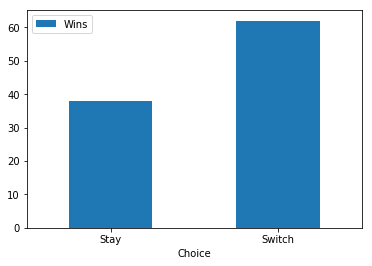

In [36]:
df = pd.DataFrame({'Choice':['Stay', 'Switch'], 'Wins':[win_list.count(0), win_list.count(1)]})
ax = df.plot.bar(x='Choice', y='Wins', rot=0)